# Проект: Классификация видеороликов по описанию  

Студия мультфильмов собирает статистику для оценки популярности различных проектов. И важно агрегировать данные по проектам, а не по отдельным роликам – агрегация статистики по проектам помогает принимать обоснованные бизнес-решения и увеличивать успех новых проектов.

**Задача**:
Нужно создать автоматизированное решение для определения принадлежности видеороликов к проектам на основе анализа текстового описания, субтитров и другой доступной информации.

Тексты могут быть на разных языках, содержать ошибки и опечатки, а также иногда отсутствовать
Ролики одного проекта могут размещаться на разных каналах
Можно с помощью Youtube API использовать дополнительную информацию, но к сожалению не все ролики могут быть обогащены данными (например, лайвы и закрытые каналы)
При разработке надо не только максимизировать метрику, но и создать наиболее гибкое и масштабируемое решение по возможности без ручной разметки


In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Загрузим необходимые библиотеки и определим константыне величины

In [2]:
!pip3 install googletrans==3.1.0a0


In [69]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier

from googletrans import Translator, constants
import os

from sklearn.metrics import make_scorer

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer

from joblib import dump, load
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [126]:
RANDOM_STATE = 12345
PATH_TRAIN = 'df_train_eng_ent.csv' 
PATH_TEST = 'df_test_eng_ent.csv'
PATH_MODEL = 'model_dt.joblib'
PATH_TARGET_DECODER = 'target_decoder.csv'


## Загрузка обучающих и тестовых датасетов и получение первичной информации по датасетам

На данном этапе проекта я уже подгружаю датасеты, которые прошли предварительную обработку и на них были получены дополнительнительно признаки:
 - reel_name_eng - название ролика, переведенное на английский     -  text_eng -  text переведенный на английский
 -   name_e - список именнованных сущностей

Обработка и получение новых признаков происходит в ноутбуке - **project_mult_preparetion**nt

### Напишем функию download_and_get_info для загрузки и получения предварительной информации о датасете

In [5]:
def download_and_get_info(path):
    '''
    Функция загрузки и первичного анализа данных.
    
    На входе функция принимает:
    path - путь к файлу
    
    На выходе возвращает: df - датасет
    
    Функция обеспечивает загрузку файла в данными, вывод на экран первых пяти строк датасета, 
    вывод общей информации о датасете, количество полных дуюликатов, описание числоовых столбцов, 
    строит гистограммы числовых столбцов, выводит по всем столбцам датасета количество уникальных 
    значений и пропусков
    
    '''
    if os.path.exists(path):
        df = pd.read_csv(path, lineterminator='\n') # загрузка файла
    else:
        print('Something is wrong') 
    df = pd.read_csv(path, lineterminator='\n') # загрузка файла
    display(df.head()) # вывод первых пяти строк датасета
    print('-' * 60)
    df.info() # вывод общей информации о датасете
    print('-' * 60)
    print('Количество полных дубликатов', df.duplicated().sum())
    print('-' * 60)
    print(df.describe())
    df.hist();
    columns = df.columns
    print('-' * 60)
    for column in columns:
        print('-' * 60)
        print(f'столбец {column}')
        print ('Количество уникальных значений', len(df[column].unique()))
        print ('Количество пропусков', df[column].isna().sum())
    return df    

### Обучающающий датасет

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"['100', 'only one']"
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN,BUGGED Lisa in Real Life ARTHUR and NASTYA Fol...,[LIZA BUGGED in Real Life ARTHUR and NASTYA Fo...,[]
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T..."
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN,How to make a fabric necklace with your own hands,[How to make a fabric necklace with your own h...,[]
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,['Kedoo Toons TV']


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83411 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83411 non-null  float64
 15  language         497 non-null    object 
 1

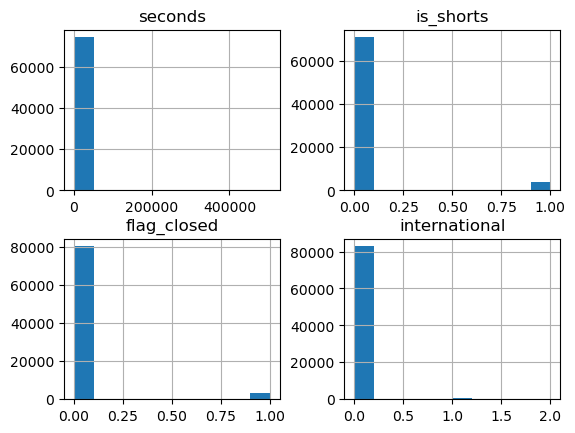

In [6]:
df_train = download_and_get_info(PATH_TRAIN)

Из полученных данных видим, что обучающий датафрейм содержит 83 411 строк и 19 столбцов, полных дубликатов нет. В ряде столбцов (seconds, is-shorts, broadcast, language) наблюдается достаточно большое количество пропусков. Столбцы - broadcast,is_shorts, flag_closed, - имеют только два значения 1 и 0, но в них есть пропуски. Пропущенные значения в столбце international были при предобработке данных заменены на 2, что подразумевает "unknown". В новых признаках reel_name_eng,   text_en,   name_e пропусков нет. nt

In [163]:
df_train['cartoon'].value_counts()

cartoon
none                          78231
Маша и медведь                  853
Говорящий Том                   589
Буба                            529
Кошечки собачки                 437
Енотки                          379
Бэтмен                          353
ЖилаБыла Царевна                229
Оранжевая корова                227
Зебра в клеточку                188
Фиксики                         151
Чик-Чирикино                    137
Сумка                           134
Черепашки Ниндзя                104
Чуддики                          86
My little pony                   81
Свинка Пеппа                     69
Синий трактор                    67
Чучело-Мяучело                   64
Малышарики                       60
Пороро                           51
Приключения Пети и Волка         41
Смешарики                        41
Трансформеры                     40
Простоквашино                    35
Царевны                          32
Щенячий патруль                  32
Cry babies magic tea

В целевой переменной cartoon наблюдается сильный дисбаланс классов, значение none превышает 90%, это надо учесть при разработке решения по калссификации. 

### Тестовый датасет

Проводим аналогичные исследования, с учетом того, что в тестовом датасете отсутсвует целевая переменная

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN,five little monsters halloween rhymes nursery ...,[five little monsters halloween rhymes nursery...,"['five', 'Kids Tv', 'Russia']"
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0.0,NaN,Tractor mini Bulldozer to making concrete road...,[Tractor mini Bulldozer to making concrete roa...,"['Bulldozer', 'Road Roller']"
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN,Who is the Last to STOP DRIVING Won the Challenge,[Who is the Last to STOP DRIVING Won the Chall...,[]
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0.0,NaN,Cartoons about cars and trains for children. E...,[Cartoons about cars and trains for children. ...,[]
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0.0,NaN,TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 PL...,[TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 P...,[]


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
 15  reel_name_eng    55608 non-null  object 
 1

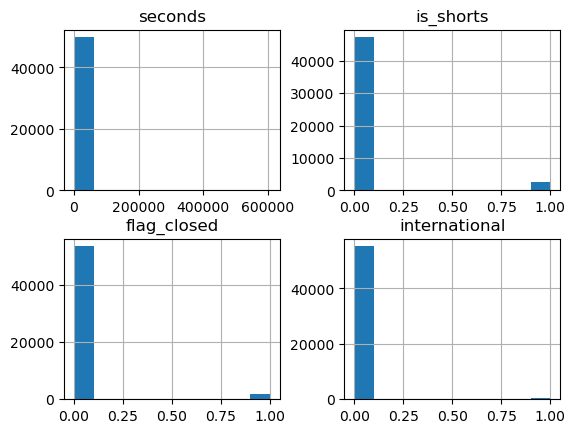

In [8]:
df_test = download_and_get_info(PATH_TEST)

Из полученных данных видим, что тестовый датафрейм содержит 55608  строк и 18 столбцов (отсутвует столбец с целевой переменной cartoon), полных дубликатов нет. В данных наблюдается схожая с обучающей выборкой картина. В столбцах seconds, is-shorts, broadcast, language достаточно большое количество пропусков. Столлбцы - broadcast,is_shorts, flag_closed, international - имеют только два значения 1 и 0, но в них есть пропуски. В столбце international есть пропуски, их надо заменить на 2, аналогично обучающей выборке

**Вывод:** Провели загрузку данных и первичное ознакомление с ними. Видим что структура данных обучающей и тестовой выборки совпадают, за исключением столбца cartoon, который является целевой переменной и отсутсвует в тестовой выборкен. В данных нет полных дубликатов, присутвуют пропуски, которые для отдельных признаков надо попробовать обработать. В целевой переменной наблюдается сильный дисбаланс классов. 

### Посмотрим sample_submission.csv 

In [10]:
submission_sampl = pd.read_csv('submission.csv')
submission_sampl.head()

,yt_reel_id,prediction
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none


## Посмотрим данные более детально

### Обучающая выборка

#### Посмотрим данные, в котрых отсутсвуют название ролика

In [11]:
df_train.query('reel_name.isna()')

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent
15331,2024-09-07,NaN,_S1ro6h6Ils,none,https://www.youtube.com/watch?v=_S1ro6h6Ils,[],19.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN,in,[],[]
17756,2023-01-09,NaN,daJ0drzcYz4,none,https://www.youtube.com/watch?v=daJ0drzcYz4,[] shorts shortsviral babyalive deixaolike],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN,in,[] shorts shortsviral babyalive deixaolike],[]
66766,2022-11-08,NaN,Zu_vwE48tqI,none,https://www.youtube.com/watch?v=Zu_vwE48tqI,[] shortsviral babyalive babyalive brincadeira],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN,in,[] shortsviral babyalive babyalive brazilla],[]


Не удаляем данные строки, т.к в тестовой выборке также есть ролики с пропуском в имени

#### Посмотри зависимость между id канала и целевой 

Сделаем ссводную таблицу по id канала, названию канала и названию проекта.

In [12]:
df_train.pivot_table(index=['yt_channel_id', 'yt_channel_name','cartoon'], values='yt_reel_id', aggfunc='count')


yt_reel_id
yt_channel_id            yt_channel_name                 cartoon                   
UC-Bc-4nV2-Tk4Af2rqrmrjA HomeAnimations Мультики про тан none                   748
UC-C8a01ToQqaNCozQbNa9pg Мультфильмы Серия Kids Cartoons none                   230
                                                         Свинка Пеппа             4
UC-jHNWViReG6R_kJ6b45FdQ Family Box                      My little pony           1
                                                         none                   778
...                                                                             ...
UCxWkNmkeAL52VTJyBlIJRXw Теремок ТВ                      Сумка                    3
                                                         Трансформеры            20
                                                         Царевны                  3
UCy1D4WGprdBxv0FaC6IH-wg Лум Планет                      none                   624
UCzHZHO-Z_fR56iOpGWNgzfQ Короткая анимация               none                   559

[399 rows x 1 columns]

#### Сделаем выборку по названию канала и проектам, которые на нем показывают

In [19]:
df_train.query('yt_channel_name == "Котёнок Котэ Песенки и мультики"')['cartoon'].unique()

array(['none', 'Акуленок'], dtype=object)

Из полученных данных в сводной таблице и выборке по названию канала видно, что на ряде каналов показывают ролики только одного проекта, на ряде каналов показывают разные проекты. Названия каналов не всегда соответсвует названиям проектов, которые предсьтавлены на данном канале. Для обучения модели данный признак необходимо использовать.

#### Проверим уникальные значения признака international, изменим тим данных на цельночисленный, а затем на категориальный, также посмотри есть ли зависимость между данным признаком и целевой переменной, посмотре уникальные названия проектов на международных каналах и нет.

In [13]:
df_train['international'].unique()

array([0., 1., 2.])

In [14]:
df_train['international'] = df_train['international'].astype('int')

In [15]:
df_train['international'] = df_train['international'].astype('category')

In [16]:
df_train['international'].unique()

[0, 1, 2]
Categories (3, int32): [0, 1, 2]

In [17]:
df_train['yt_channel_id'] = df_train['yt_channel_id'].astype('category')

In [18]:
df_train.query('international == 1')['cartoon'].value_counts()

C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\643130039.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_train.query('international == 1')['cartoon'].value_counts()


cartoon
Енотки              327
Оранжевая корова    170
Name: count, dtype: int64

In [168]:
df_train.query('international == 1')['cartoon'].unique()

C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\234785200.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_train.query('international == 1')['cartoon'].unique()


array(['Енотки', 'Оранжевая корова'], dtype=object)

In [169]:
df_train.query('international != 1')['cartoon'].unique()

C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\4052858911.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_train.query('international != 1')['cartoon'].unique()


array(['none', 'Смешарики', 'Чуддики', 'Маша и медведь',
       'Кошечки собачки', 'Зебра в клеточку', 'Сумка', 'Фиксики',
       'Бэтмен', 'Черепашки Ниндзя', 'Свинка Пеппа', 'ЖилаБыла Царевна',
       'My little pony', 'Чик-Чирикино', 'Царевны', 'Котик Мормотик',
       'Буба', 'Малышарики', 'Синий трактор', 'Говорящий Том',
       'Чучело-Мяучело', 'Оранжевая корова', 'Трансформеры', 'Пороро',
       'Акуленок', 'Простоквашино', 'Цветняшки', 'Кукутики',
       'Приключения Пети и Волка', 'Губка Боб', 'Енотки',
       'Щенячий патруль', 'Enchantimals (Эншантималс)', 'Барбоскины',
       'Симпсоны', 'Чебурашка', 'Крутиксы', 'Финник',
       'Cry babies magic tears', 'Вспыш', 'Лунтик', 'Мини-мишки',
       'Бременские музыканты', 'Паровозики Чаттингтон',
       'Ну_погоди каникулы'], dtype=object)

Из полученных данных видим, что на международных каналах показывают только два проекта Енотики и Оранжевая корова, а на немеждународных или на неизвестных все проекты, которые отслеживаются. Поэтому будем использовать данный признак при обучении

## Подготовка признаков и обучение модели DecisionTreeClassifier

В данный раздел включила вариант с обучением модели DecisionTreeClassifier на том наборе признаков, который показал самый хороший вариант решения поставленной задачи. 
На тестовой выборке получила следующие значения метрики **f1 (macro)**:
 - public - 0.80435
 - privatt - 0.80943

Также в процессе выполнения данной работы были протестированы другие подходы к решению задачи, другие модели и другие наборы признаков. Данные по исследованиям модно найти в ноутбуке - **project_mult_research**

### Проведем очистку текста (оставим только буквы алфавита) и лемматизаци названия роликов. Для этого сначала напишем функцию очистки и лемматизации текста, потом применим ее ко всем значениям признака 'reel_name_eng' (название ролика на английском) обучающего датасета и сохраним их в столбце 'lemm_name'.

На вход функция lemmatize_clean_text(text) получает текст, на выходе получаем лемматизированный текст  

In [20]:
lemmatizer = WordNetLemmatizer()

In [21]:
def lemmatize_clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatizer.lemmatize(w, pos = 'v') for w in text] # лемматирзируем слова
    return ' '.join(text) # соединяем слова

df_train['lemm_name'] = df_train['reel_name_eng'].apply(lemmatize_clean_text)

df_train.head()

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent,lemm_name
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"['100', 'only one']",gift and only one you can keep for yourself
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0,NaN,BUGGED Lisa in Real Life ARTHUR and NASTYA Fol...,[LIZA BUGGED in Real Life ARTHUR and NASTYA Fo...,[],bug lisa in real life arthur and nastya follow me
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T...",the terrible family best sisterly moments with...
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0,NaN,How to make a fabric necklace with your own hands,[How to make a fabric necklace with your own h...,[],how to make a fabric necklace with your own hand
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,['Kedoo Toons TV'],sleepover rule om nom stories cartoon for kid ...


### Отбираем признаки для обучения модели, выделяем и кодируем целевую переменную

В качестве признаков будем использовать  - 'yt_channel_id', 'international', 'lemm_name'

Целевая переменная - 'cartoon'

In [22]:
df_train.columns

Index(['date', 'reel_name', 'yt_reel_id', 'cartoon', 'url', 'text', 'seconds',
       'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name',
       'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international',
       'language', 'reel_name_eng', 'text_eng', 'name_ent', 'lemm_name'],
      dtype='object')

Признаки для обучающей выборки

In [23]:
train_features = df_train[['yt_channel_id', 'international', 'lemm_name']]

In [24]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   yt_channel_id  83411 non-null  category
 1   international  83411 non-null  category
 2   lemm_name      83411 non-null  object  
dtypes: category(2), object(1)
memory usage: 906.0+ KB


В переменной cat_columns сохраняем названия категориальных столбцов, в text_columns - столбцы с текстом

In [26]:
cat_columns = train_features.select_dtypes(include='category').columns
text_columns = train_features.select_dtypes(include='object').columns
print(cat_columns)
text_columns

Index(['yt_channel_id', 'international'], dtype='object')


Index(['lemm_name'], dtype='object')

Целевая переменная для обучающей выборки

In [27]:
train_target = df_train['cartoon']

In [33]:
train_c = pd.DataFrame(train_target)

In [34]:
train_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cartoon  83411 non-null  object
dtypes: object(1)
memory usage: 651.8+ KB


Кодируем значениия целевой переменной с помщью OrdinalEncoder()

In [35]:
encoder = OrdinalEncoder()

In [36]:
train_c['cartoon_encod'] = encoder.fit_transform(train_c[['cartoon']])

In [37]:
train_c['cartoon_encod'] = train_c['cartoon_encod'].astype('int')

In [38]:
train_c.head()

,cartoon,cartoon_encod
0,none,3
1,none,3
2,none,3
3,none,3
4,none,3


In [170]:
train_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cartoon        83411 non-null  object
 1   cartoon_encod  83411 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 977.6+ KB


Создаем таблицу с названием проекта и кодом проекта, чтобы в дальнейшем раскодироватьт полученные результат

In [40]:
target_encoder = train_c.pivot_table(index=['cartoon', 'cartoon_encod']).reset_index()
target_encoder

,cartoon,cartoon_encod
0,Cry babies magic tears,0
1,Enchantimals (Эншантималс),1
2,My little pony,2
3,none,3
4,Акуленок,4
5,Барбоскины,5
6,Бременские музыканты,6
7,Буба,7
8,Бэтмен,8
9,Вспыш,9


Записываем файл с кодированными названиями проектов

In [125]:
# target_encoder.to_csv('target_decoder.csv', index=False)

## Обучение модели DecisionTreeClassifier

### Подгатавливаем признаки для обучения модели

Категориальные признаки -  кадируем с помощью OrdinalEncoder

Текстовые признаки - обрабатываем с помощью TfidfVectorizer с удалением стоп слов

Обработку признаков проводим с помощью Сolumn_transformer

In [28]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
column_transformer_rf = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,  dtype=np.float32), cat_columns),
                                                (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 2),
                                                                                          remainder = 'passthrough')


In [31]:
train_features_rf = column_transformer_rf.fit_transform(train_features)

In [32]:
train_features_rf 

<83411x18480 sparse matrix of type '<class 'numpy.float32'>'
	with 642261 stored elements in Compressed Sparse Row format>

In [41]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [42]:
score = cross_val_score(estimator=model_dt,
                            X=train_features_rf,
                            y=train_c['cartoon_encod'],
                            scoring=make_scorer(f1_score, average='macro'),
                            cv=2)

In [43]:
score

array([0.74469805, 0.6917298 ])

На кроссвалидации получили достаточно неплохое значение метрики, попробуем подобрать гиперпараметры для ее улучшения.

### Подбор гимперпараметров для модели решающее дерево

In [44]:
pipline_dt = make_pipeline(column_transformer_rf, model_dt)
pipline_dt 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['yt_channel_id', 'international'], dtype='object')),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                                                  stop_words=['out',
                                                                              'me',
                                                                              'can',
                                                                              'more',
                                                                              "didn't",
                                                                              'off',
                                                                              'your',
                                                                              'that',
                                                                              'then',
                                                                              'as',
                                                                              'themselves',
                                                                              'its',
                                                                              'some',
                                                                              'o',
                                                                              'herself',
                                                                              'nor',
                                                                              'most',
                                                                              'hadn',
                                                                              'my',
                                                                              'them',
                                                                              'hasn',
                                                                              'from',
                                                                              'through',
                                                                              'being',
                                                                              'd',
                                                                              'ourselves',
                                                                              'weren',
                                                                              'after',
                                                                              'didn',
                                                                              'ma', ...]),
                                                  2)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=12345))])

In [45]:
              
param_dt = {
    'decisiontreeclassifier__max_depth': range(1, 150),
    'decisiontreeclassifier__min_samples_split': (2, 3, 4),
    'decisiontreeclassifier__min_samples_leaf': (1, 2, 3, 4),
   
}



grid_dt = RandomizedSearchCV(pipline_dt, param_dt, cv=2, n_iter=150, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_dt.fit(train_features, train_c['cartoon_encod'])


dt_best_f1 = grid_dt.best_score_
dt_best_model = grid_dt.best_estimator_
dt_best_params = grid_dt.best_params_
           

print(f'F1 лучшей модели DecisionTreeClassifier на обучающей выборке: {dt_best_f1}')
print(f'Гиперпараметры лучшей модели: {dt_best_params}')

F1 лучшей модели DecisionTreeClassifier на обучающей выборке: 0.7206844463798723
Гиперпараметры лучшей модели: {'decisiontreeclassifier__min_samples_split': 3, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_depth': 126}


Сохраняем лучшую модель, с параметрами : {'decisiontreeclassifier__min_samples_split': 3, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_depth': 126}

In [70]:
#dump(dt_best_model, 'model_dt.joblib')

['model_dt.joblib']

## Получение предсказаний на тестовой выборке для модели решающее дерево

In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
 15  reel_name_eng    55608 non-null  object 
 16  text_eng         55608 non-null  object 
 17  name_ent    

### Подготовим данные тестовой выбоки для получения предсказаний

Получаем лемматизированный и очищенный текс названия ролика на английском

In [47]:
df_test['lemm_name'] = df_test['reel_name_eng'].apply(lemmatize_clean_text)


Заполняем пропуски "unknown" в признаке 'yt_channel_id' и меняем тип данных на категориальный

In [48]:
df_test['yt_channel_id'] = df_test['yt_channel_id'].fillna('unknown')


In [49]:
df_test['yt_channel_id'] = df_test['yt_channel_id'].astype('category')

Заполняем пропуски в признаке international 2, меняем тип данных на цельночисленный, а потом на категориальный

In [50]:
df_test['international'] = df_test['international'].fillna(2)

In [51]:
df_test['international'] = df_test['international'].astype('int')

In [52]:
df_test['international'] = df_test['international'].astype('category')

In [53]:
df_test['international'].value_counts()

international
0    55243
1      337
2       28
Name: count, dtype: int64

In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   date             55608 non-null  object  
 1   reel_name        55605 non-null  object  
 2   yt_reel_id       55608 non-null  object  
 3   url              55608 non-null  object  
 4   text             55608 non-null  object  
 5   seconds          49807 non-null  float64 
 6   is_shorts        49807 non-null  float64 
 7   broadcast        49807 non-null  object  
 8   yt_channel_id    55608 non-null  category
 9   yt_channel_name  55580 non-null  object  
 10  yt_ch_url        55580 non-null  object  
 11  yt_channel_type  55580 non-null  object  
 12  flag_closed      55580 non-null  float64 
 13  international    55608 non-null  category
 14  language         337 non-null    object  
 15  reel_name_eng    55608 non-null  object  
 16  text_eng         55608 non-null  object 

### Отбираем признаки для тестовой выборки и получаем предсказания

In [55]:
test_features = df_test[['yt_channel_id', 'international', 'lemm_name']]

In [56]:
prediction_dt = dt_best_model.predict(test_features)

In [57]:
prediction_dt

array([ 3,  3,  3, ..., 32,  3,  3])

In [58]:
predictions_test_dt = pd.Series(prediction_dt)

Добавляем получившиеся предсказания к тестовой выборке

In [59]:
df_test['prediction'] = predictions_test_dt
df_test.head()

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent,lemm_name,prediction
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0,NaN,five little monsters halloween rhymes nursery ...,[five little monsters halloween rhymes nursery...,"['five', 'Kids Tv', 'Russia']",five little monsters halloween rhyme nursery r...,3
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0,NaN,Tractor mini Bulldozer to making concrete road...,[Tractor mini Bulldozer to making concrete roa...,"['Bulldozer', 'Road Roller']",tractor mini bulldozer to make concrete road c...,3
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0,NaN,Who is the Last to STOP DRIVING Won the Challenge,[Who is the Last to STOP DRIVING Won the Chall...,[],who be the last to stop drive win the challenge,3
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0,NaN,Cartoons about cars and trains for children. E...,[Cartoons about cars and trains for children. ...,[],cartoon about cars and train for children educ...,3
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0,NaN,TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 PL...,[TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 P...,[],too small portal to end in minecraft only play...,3


В переменной sub сохраняем только два поля id  ролика и предсказание

In [60]:
sub = df_test[['yt_reel_id','prediction']]
sub.head()

,yt_reel_id,prediction
0,RBw4j0aMWyM,3
1,5wTfpmlZe5k,3
2,Fd9YA-oDjSo,3
3,NXCHY_J-5v0,3
4,XM-GRekoYzs,3


In [61]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   yt_reel_id  55608 non-null  object
 1   prediction  55608 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 651.8+ KB


In [62]:
sub.rename(columns={"prediction": "cartoon_encod"}, inplace=True )


C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\4124640158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.rename(columns={"prediction": "cartoon_encod"}, inplace=True )


In [63]:
sub.head()

,yt_reel_id,cartoon_encod
0,RBw4j0aMWyM,3
1,5wTfpmlZe5k,3
2,Fd9YA-oDjSo,3
3,NXCHY_J-5v0,3
4,XM-GRekoYzs,3


Добавляем к получившейся таблице sub название проекта по его номеру, используя полученную ранее таблицу для раскодирования названия проектов

In [64]:
sub_1 = sub.merge(target_encoder, on='cartoon_encod', how='left')

In [65]:
sub_1 = sub_1.drop('cartoon_encod', axis=1)

In [66]:
sub_1.rename(columns={"cartoon": "prediction"}, inplace=True)

In [67]:
sub_1

,yt_reel_id,prediction
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none
...,...,...
55603,z8QQtWqr7lY,none
55604,VMBC_ahkjjU,none
55605,zwSu3nUWQKM,Смешарики
55606,yieUVOAHZiA,none


Сохраняем предсказания в файл

In [68]:
#sub_1.to_csv('submission_dt_2.csv', index=False)

## Напишем функцию для получения предсказания, к какому проекту относится ролик при вводе его id номера


На входе функция принимает: список id роликов с YouTube (один или несколько)

На выходе возвращает: список словарей сназванием проекта, к которому относится ролик, или none, если ролик не относится ни к одному проекту

In [152]:
def get_name_project(list_id):
        
    if os.path.exists(PATH_TEST):
        data = pd.read_csv(PATH_TEST, lineterminator='\n') #загружаем данные тестовой выборки
    else:
        print('Проверь путь к файлу с данными') 
        
    try:
        df = data.loc[data.loc[:,'yt_reel_id'].isin(list_id)]
    except:
        print('There is no such id')

    df['yt_channel_id'] = df['yt_channel_id'].fillna('unknown') # заменяем пропуски в признаке 'yt_channel_id' на unknown и 
                                                                                  
    df['yt_channel_id'] = df['yt_channel_id'].astype('category')  # и меняем тип данных на категориальный
    df['international'] = df['international'].fillna(2).astype('int') # заполняем пропуски значением 2, что для наз означает unknown
    df['international'] = df['international'].astype('int')    # меняем тип данных на цельночисленный, а потом на категориальный
    df['international'] = df['international'].astype('category')
    
    translator = Translator()
    def get_translate(text):
        '''
        Функция перевода текста с помощью googletrans
        На входе функция принимает: текст
        На выходе возвращает: переведенный текст или значение 'unknown', если текст перевести не удалось 
      
        '''
        try:
            translation_name = translator.translate(text, dest="en")
            return translation_name.text
        except:
            return "unknown"

    df['reel_name_eng'] = df['reel_name'].apply(get_translate) # переводим текст

    lemmatizer = WordNetLemmatizer()
    def lemmatize_clean_text(text):
        '''
        Функция лемматизации и очистки текста
        На входе функция принимает: текст
        На выходе возвращает:очищенный и лемматизированный текст 
      
        '''
        text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
        text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
        text = [lemmatizer.lemmatize(w, pos = 'v') for w in text] # лемматирзируем слова
        return ' '.join(text) # соединяем слова

    df['lemm_name'] = df['reel_name_eng'].apply(lemmatize_clean_text) #лемматизируем текст
    test = df[['yt_channel_id', 'international', 'lemm_name']]
        
    try:
        model = load(PATH_MODEL)
    except:
        print('Проверь путь к файлу с моделью')  
        
    prediction = model.predict(test)
    df['cartoon_encod'] = prediction

    if os.path.exists(PATH_TARGET_DECODER):
        target_decoder = pd.read_csv(PATH_TARGET_DECODER) # загрузка файла
    else:
        print('Проверь путь к файлу с данными') 
    df = df.merge(target_decoder, on='cartoon_encod', how='left')
    df = df[['yt_reel_id', 'cartoon']]
    df_dict = df.to_dict('records')
    return df_dict

Протестируем получившуюся функциию на одном id проекта - 'RBw4j0aMWyM'

In [161]:
df = get_name_project(list_id = ['RBw4j0aMWyM'])

C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\3094276715.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['yt_channel_id'] = df['yt_channel_id'].fillna('unknown') # заменяем пропуски в признаке 'yt_channel_id' на unknown и
C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\3094276715.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['yt_channel_id'] = df['yt_channel_id'].astype('category')  # и меняем тип данных на категориальный
C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\3094276715.p

In [162]:
df

[{'yt_reel_id': 'RBw4j0aMWyM', 'cartoon': 'none'}]

Тестируем функцию на списе id проектов. Для этого из тестовой выборке произвольно выбираем 30 'yt_reel_id'сохраняем их в переменной list и подаем в функцию get_name_project

In [155]:
list = df_test.sample(30)['yt_reel_id']

In [157]:
list = list.to_list()

In [158]:
list

['2A2Kvbul9kM',
 'hf7pzf8lZ74',
 'jwWqKp9PlIo',
 'ZTdNhRzDh1E',
 'Z0lGbF6Go88',
 'wGWmDsCVLQU',
 'kXTqf3Oyj_M',
 'JgduMmMSkeo',
 'igevAafkEb8',
 '4yuoTsR-SXA',
 'HvNQA-_s-uA',
 'acfjODwHfu8',
 'ucLVDgK2OWQ',
 'SlC_s39UbMA',
 'W8hOtVO__J4',
 'Qdp-mMMQGg0',
 '6NivyFpmnrk',
 'AkzmucrPPEo',
 'NMJ1sFqmihU',
 'yxZPJ5SXsx4',
 'HsbSsHDT3t8',
 'vVtt0sbNdN0',
 'DCtC9NOD2_w',
 't0uZz_nu0zE',
 'L0RBLIJ8rGg',
 'b6flPjzBFPw',
 '8Na2FWicv60',
 '__9N8GUBQQA',
 'VHd6M2WE6fY',
 'L7slauq45r4']

In [159]:
df_list = get_name_project(list_id = list)

C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\3094276715.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['yt_channel_id'] = df['yt_channel_id'].fillna('unknown') # заменяем пропуски в признаке 'yt_channel_id' на unknown и
C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\3094276715.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['yt_channel_id'] = df['yt_channel_id'].astype('category')  # и меняем тип данных на категориальный
C:\Users\bniko\AppData\Local\Temp\ipykernel_14664\3094276715.p

In [160]:
df_list

[{'yt_reel_id': 'HsbSsHDT3t8', 'cartoon': 'none'},
 {'yt_reel_id': 'L7slauq45r4', 'cartoon': 'none'},
 {'yt_reel_id': 'vVtt0sbNdN0', 'cartoon': 'none'},
 {'yt_reel_id': 'SlC_s39UbMA', 'cartoon': 'none'},
 {'yt_reel_id': 'VHd6M2WE6fY', 'cartoon': 'none'},
 {'yt_reel_id': 'L0RBLIJ8rGg', 'cartoon': 'none'},
 {'yt_reel_id': 'JgduMmMSkeo', 'cartoon': 'none'},
 {'yt_reel_id': 'Qdp-mMMQGg0', 'cartoon': 'none'},
 {'yt_reel_id': '__9N8GUBQQA', 'cartoon': 'none'},
 {'yt_reel_id': 'W8hOtVO__J4', 'cartoon': 'none'},
 {'yt_reel_id': 'yxZPJ5SXsx4', 'cartoon': 'none'},
 {'yt_reel_id': '4yuoTsR-SXA', 'cartoon': 'none'},
 {'yt_reel_id': 'ZTdNhRzDh1E', 'cartoon': 'none'},
 {'yt_reel_id': 'kXTqf3Oyj_M', 'cartoon': 'none'},
 {'yt_reel_id': 'jwWqKp9PlIo', 'cartoon': 'none'},
 {'yt_reel_id': 'Z0lGbF6Go88', 'cartoon': 'none'},
 {'yt_reel_id': 'AkzmucrPPEo', 'cartoon': 'none'},
 {'yt_reel_id': 'HvNQA-_s-uA', 'cartoon': 'Буба'},
 {'yt_reel_id': 'wGWmDsCVLQU', 'cartoon': 'none'},
 {'yt_reel_id': 't0uZz_nu0zE', 

**Итоговый вывод**

В процессе работы над проектом было проделано следующее:

1. Загружены и обработаны первоначальные данные (обучающий и тестовый датасет). Были заполнены пропуски в столбцах 'yt_channel_id' на "unknown", а в столбце 'international' на 2, изменен тип данных в этих столбцах на категориальный. Добавлены колонки с новыми признаками reel_name_eng - назвние ролика на английском,  text_eng -  текс на анлийском, name_ent - именнованние сущности из столбца название проекта на английском. Перевод осуществлялся с помощью  googletrans, а извлечение именованных сущноситей с помощью библиотеки spacy.
Предварительная обработка делалась в ноутбуке - **project_mult_preparetion**

2. Проведены исслоедования нескольких моделей и наборов признаков для поиска лучшего решения поставленной задачи - максимизации метрики F1(macro), а также получения макисмально автоматизированного и масштабируемого решения.

- Рассматривался вариант в с получением эмбедингов текста с помощью мультилингвистической модели BERT 'bert-base-multilingual-cased' и модели логистической регрессии. Данный вариант дал предсказания на тестовой выборке F1 порядка 0.35
- Рассматривались модели решающего дерева DecisionTreeClassifier, случайного леса RandomForestClassifier и логистической регресии LogisticRegression на на следующем наборе признаков ['yt_channel_id', 'international', 'lemm_name']. Наиболее хороший результат показала модель DecisionTreeClassifier, которая дала результат на тестовой выборке F1 порядка 0.80943.
- Расссматривались модели DecisionTreeClassifier,  на следующем надоре признаков ['yt_channel_id', 'international', 'name_ent', 'lemm_name', 'name_cap', 'name_len'] LogisticRegression. Однако дабавление новых признаков - 'name_ent' - именнованные сущности, выделенные из английского названия ролика, 'name_cap' - список слов, написанный с заглавной буквы, 'name_len' - длина названия ролика не привели к улучшению метрики
- Модель DecisionTreeClassifier на следующем надоре признаков - ['yt_channel_id', 'lemm_name']. Здесь получили метрику на тестовой выборке F1 порядка  0.806
- Также рассматривался вариант разделения датасетов на части, сначала выбирали международные каналы и обучали модель для их предсказания, с этими данными хорошо справляется модель DecisionTreeClassifier на дефольных значениях и дает метрику F1 =1, далее предполагалось сделать модель, которая будет предсказывать результат для роликов, не относящихся к международным каналам, но из названия которых удалось извлечь именованные сущности. тут удалось получить модель  DecisionTreeClassifier с F1 на обучающей выборке на кроссвалидации порядка 0.702. Далее наlо было обучить модель для определения проекта на оставшейся части данных (немеждународный канал и не смогли выделить выделить именнованные сущности). Вот для этих данных не удалось получить модель, которая смогла бы хорошо предсказывать данные c хорошим результатом - получил на DecisionTreeClassifier f1 на кросвалидации порядка 0.5359.

Данные по исследованиям модно найти в ноутбуке - **project_mult_research**

**Таким образом для реализации задачи проекта была выбрана модель DecisionTreeClassifier с параметрами {'decisiontreeclassifier__min_samples_split': 3, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_depth': 126}, обученная на следующем наборе признаков - ['yt_channel_id', 'international', 'lemm_name'].**

Обучение данной модели приведено в текущей тетради.

На данной модели удалосm получить следующие показатели метрики f1(macro):
- public - 0.80435
- privatt - 0.80943

3. Была разработана и протестирована функция **get_name_project(list_id)** для категоризации роликов по проектам.

На вход данной функции подается список id роликов с YouTube. Список может содержать как один id ролика, так и несколько. 
Для работы функции необходимы:
- данные из тестовой выборки или любой другой выборки, которая должна содержать поля:
  - yt_reel_id - id ролика на YouTube
  - reel_name - название ролика с YouTube
  - yt_channel_id - id канала ролика на YouTube
  - international - международный канал или нет
- обученная модель DecisionTreeClassifier (model_dt.joblib)
- декодер значения целевой переменной, чтобы перевести предсказания модели в названия проектов (target_decoder.csv)
   
На выходе функция выдает список словарей типа
[{'yt_reel_id': 'HsbSsHDT3t8', 'cartoon': 'none'},...
 {'yt_reel_id': 'L7slauq45r4', 'cartoon': 'none']
 ,